# Predictive Modelling Store Count using various regressor models.

# System Setting

RAM: 30 GB  
CPUS: 8  
HD: 210.5 KB / 100 GB  
GPU: 8 GB  


In [1]:
import sys
import warnings
import pandas as pd
import sklearn
import sklearn.preprocessing
import numpy as np
import seaborn as sns
import operator

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn import linear_model
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
train_df = pd.read_csv("train_data.csv")

In [3]:
test_df = pd.read_csv("test_data.csv")

In [4]:
seed = 7
np.random.seed(seed)

# How did you preprocess the data and why?

### Categorical Feature Transformation

There are 4 categorical features.
1. device_angle -  with 3 categories
2. distance_to_door - with 3 categories
3. AM_or_PM  - with 2 categories
4. mall_or_street - with 2 categories

I created a set of dummy variables (number of categories) for each categorical variables. Therefore 3+3+2+2 => 10 columns are generated from the 4 columns. Both training and test data did not contain a category of distance_to_door column ("gt_four_m"). Therefore precisely 4 => 9

for example a datapoint has device_angle = 2 => 0 1 0

### Numerical Feature Transformation

1. average_person_size

    Average person pixel in foreground. I interpreted it as average area occupied by a person in a video which is of area $480*320$. Therefore its a proportional average area captured in a single frame of a video. 
    
    average_person_size = average_person_size/(480*320).  
    After which I scaled them to zero mean and 2 standard deviations.
    
    

2. All other numerical features( except for target output):
    
   
   - video_walkin
   - video_walkout
   - predict_walkin
   - predict_walkout
   - wifi_walkin
   - wifi_walkout
   - sales_in_next_15_min
   - sales_in_next_15_to_30_min



   I visualised all other numerical features. They seem to have a left skewed distribution with a long tail towards the right. Their range seemed to be smaller. Hence I standardised their values to 0 mean and 2 standard deviations.
    



/home/paperspace/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


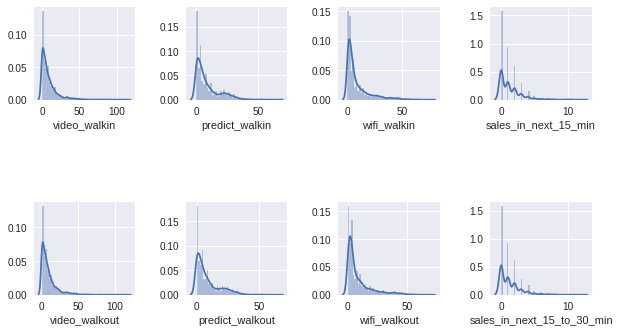

In [5]:
fig, ax = plt.subplots(figsize=(10,5), ncols=4, nrows=2)

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .5     # the amount of width reserved for blank space between subplots
hspace =  1.1    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)

# The amount of space above titles
y_title_margin = 1.2



ax[0][0].set_xlabel("video_walkin")
ax[0][1].set_xlabel("predict_walkin")
ax[0][2].set_xlabel("wifi_walkin")
ax[0][3].set_xlabel("sales_in_next_15_min")

sns.distplot(train_df["video_walkin"],ax=ax[0][0])
sns.distplot(train_df["predict_walkin"],ax=ax[0][1])
sns.distplot(train_df["wifi_walkin"],ax=ax[0][2])
sns.distplot(train_df["sales_in_next_15_min"],ax=ax[0][3])

ax[1][0].set_xlabel("video_walkout")
ax[1][1].set_xlabel("predict_walkout")
ax[1][2].set_xlabel("wifi_walkout")
ax[1][3].set_xlabel("sales_in_next_15_to_30_min")

sns.distplot(train_df["video_walkout"],ax=ax[1][0])
sns.distplot(train_df["predict_walkout"],ax=ax[1][1])
sns.distplot(train_df["wifi_walkout"],ax=ax[1][2])
sns.distplot(train_df["sales_in_next_15_to_30_min"],ax=ax[1][3])

In [6]:
def get_processed_df(dataFrame):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        df = dataFrame.copy()

        angle_df = pd.get_dummies(df["device_angle"])
        angle_df.rename(columns={1:"less_thirty",2:"thirty_sixty",3:"sixty_ninety"},inplace=True)

        distance_df = pd.get_dummies(df["distance_to_door"])
        distance_df.rename(columns={1:"less_two_m",2:"two_four_m",3:"gt_four_m"},inplace=True)

        period_df = pd.get_dummies(df["AM_or_PM"])
        period_df.rename(columns={0:"AM",1:"PM"},inplace=True)

        place_df = pd.get_dummies(df["mall_or_street"])
        place_df.rename(columns={1:"Mall",2:"Street"},inplace=True)

        new_df = pd.concat([df,angle_df,distance_df,period_df,place_df],axis=1)

        new_df.drop("device_angle",inplace=True,axis=1)
        new_df.drop("distance_to_door",inplace=True,axis=1)
        new_df.drop("AM_or_PM",inplace=True,axis=1)
        new_df.drop("mall_or_street",inplace=True,axis=1)

        new_df['average_person_size'] =  sklearn.preprocessing.scale(df['average_person_size']/(480*320))
        new_df['video_walkin'] =  sklearn.preprocessing.scale(df['video_walkin'])
        new_df['video_walkout'] = sklearn.preprocessing.scale(df['video_walkout'])
        new_df['predict_walkin'] = sklearn.preprocessing.scale(df['predict_walkin'])
        new_df['predict_walkout'] = sklearn.preprocessing.scale(df['predict_walkout'])
        new_df['wifi_walkin'] = sklearn.preprocessing.scale(df['wifi_walkin'])
        new_df['wifi_walkout'] = sklearn.preprocessing.scale(df['wifi_walkout'])
        new_df['sales_in_next_15_min'] = sklearn.preprocessing.scale(df['sales_in_next_15_min'])
        new_df['sales_in_next_15_to_30_min'] = sklearn.preprocessing.scale(df['sales_in_next_15_to_30_min'])


        return new_df

In [7]:
normalised_tdf = get_processed_df(train_df)

In [8]:
norm_test_df =  get_processed_df(test_df)

In [9]:
def train_test_splits(df):
    Y = np.array(df['groundtruth_walkin'])
    X = df.ix[:, df.columns != 'groundtruth_walkin'].as_matrix()
    return train_test_split(X, Y, test_size=0.3, random_state=0)

In [10]:
X_train, X_cv, y_train, y_cv = train_test_splits(normalised_tdf)

# Linear Model Tests

In [11]:
def all_linear_Models(X_train,y_train,X_cv,y_cv,case):
    m_dict = {}
    baseline_mean_train = np.mean(y_train)* np.ones(len(y_train))
    baseline_mean_cv =  np.mean(y_train)* np.ones(len(y_cv))
    
    
    case = case
    reg =  None
    # Lasso Regression => Avoid features when they are not significant, Modeled with Default params
    # Has L1 regulariser. Does not have L2 Norm involved. Generally has no effect on 
    if case==1:
        reg = linear_model.LassoCV()
        reg.fit(X_train,y_train)
        m_dict["Lasso_cv_r2"] =  reg.score(X_cv,y_cv)
        m_dict["Lasso_train_r2"] =reg.score(X_train,y_train)
        case+=1
        reg=None
    
    # ElasticNet => Utilises both L1 and L2 penalty as prior regularizer constant.
    # ElasticNetCV => decides which Regulariser to weigh based on the l1_ratio_ value
    # if l1_ratio_== 0 then the model will be devoid of l1 penalty
    # else if l1_ratio ==1 then model will be devoid of l2 penalty.
    
    if case==2:
        reg = linear_model.ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
        reg.fit(X_train,y_train)
        m_dict["ElasticNet_cv_r2"] =  reg.score(X_cv,y_cv)
        m_dict["ElasticNet_train_r2"] =reg.score(X_train,y_train)
        case+=1
        reg = None
    
    # SGD Regressor => Works for Many datapoints with multiple features ( for a n*p matrix both n and p has to be high)
    # Loss function used => Huber loss, which means to calculate L2 loss till a threshold (epsilon =0.8) and calculate L1 after
    # the threshold to avoid the effect of outliers in the model
    if case==3:
        reg = linear_model.SGDRegressor(loss='huber',epsilon=0.8)
        reg.fit(X_train,y_train)
        m_dict["SGD_cv_r2"] =  reg.score(X_cv,y_cv)
        m_dict["SGD_train_r2"] =reg.score(X_train,y_train)
        case+=1
        reg = None
        
    
    # Huber Regressor => is better than SGD regressor with lesser huber loss for lesser number of datapoints
    # Its scale invariant. Hence using Huber Regressor
    if case==4:
        reg = linear_model.HuberRegressor()
        reg.fit(X_train,y_train)
        m_dict["Huber_cv_r2"] =  reg.score(X_cv,y_cv)
        m_dict["Huber_train_r2"] =reg.score(X_train,y_train)
        case+=1
        reg = None
    
    # Trying Ensemble Weak learners => Gradient Boosting Regressor
    if case==5:
        reg = GradientBoostingRegressor(n_estimators=200)
        reg.fit(X_train,y_train)
        
        kfold = KFold(n_splits=5, random_state=seed)
        m_dict['Avg_5_fold_GBR_r2']= np.mean(cross_val_score(reg,X_train,y_train,cv=kfold))
        m_dict["GBR_cv_r2"] =  reg.score(X_cv,y_cv)
        m_dict["GBR_train_r2"] =reg.score(X_train,y_train)
        df = pd.DataFrame({"gbr_predict_cv":reg.predict(X_cv),"actual":y_cv})
        case+=1
        
        
        
        
    
    return (m_dict,df,reg)
    

In [12]:
model_dict,df,model = all_linear_Models(X_train,y_train,X_cv,y_cv,1)

In [13]:
print("Mean Squared Error for Gradient Boosting is {0} ".format(sklearn.metrics.mean_squared_error(df.actual,df.gbr_predict_cv)))

Mean Squared Error for Gradient Boosting is 35.69887388325935 


In [14]:
new_model_list = sorted(model_dict.items(), key=operator.itemgetter(1), reverse=True)[:2]
print("Best Model - Gradient Boosting Train set R2 score {0} and holdout set R2 score {1}".format(new_model_list[0][1],new_model_list[1][1]))


Best Model - Gradient Boosting Train set R2 score 0.9532820102154073 and holdout set R2 score 0.8800100773701256


In [15]:
test_df["walk_in_pred_GBR"] =np.floor(model.predict(norm_test_df))

# Baseline Neural Network

In [16]:
# define base model
def baseline_nn_model():
    
    # create model
    model = Sequential()
    model.add(Dense(25, input_dim=18, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1,kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse','accuracy'])
    model.save("baseline_nn.h5")
    return model

In [17]:
def deep_nn_model():
    
    # create model
    model = Sequential()
    model.add(Dense(25, input_dim=18, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1 ,kernel_initializer='normal'))
    # Compile model
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse','accuracy'])
    model.save("dense_model.h5")
    return model

In [18]:

def evaluate_nn_model(model_obj,x_tr,x_cv,y_tr,y_cv,t_df=pd.DataFrame()):
    y_test = None
    estimator = KerasRegressor(build_fn=model_obj,epochs=300, batch_size=32, verbose=0)
    estimator.fit(x_tr,y_tr,validation_split=0.2) 
    x_train_pred =  estimator.predict(x_tr)
    x_cv_pred = estimator.predict(x_cv)
    if not t_df.empty:
        
        test_df_pred = t_df.values
        y_test = np.floor(estimator.predict(test_df_pred))
        
    return(r2_score(y_tr,x_train_pred),r2_score(y_cv,x_cv_pred),y_test)
    

In [19]:
r2_train, r2_holdout, y_test = evaluate_nn_model(baseline_nn_model,X_train,X_cv,y_train,y_cv)
print("R2 for Baseline NN Train is {0} and R2 for Baseline NN holdout is {1}".format(r2_train,r2_holdout))

R2 for Baseline NN Train is 0.873918724395689 and R2 for Baseline NN holdout is 0.8446607660961692


In [20]:
r2_deep_train, r2_deep_holdout,y_test = evaluate_nn_model(deep_nn_model,X_train,X_cv,y_train,y_cv,t_df=norm_test_df)
print("R2 for deep NN Train is {0} and R2 for Baseline NN holdout is {1}".format(r2_deep_train,r2_deep_holdout))

R2 for deep NN Train is 0.8910437096202082 and R2 for Baseline NN holdout is 0.8591862908801233


In [21]:
test_df["walk_in_pred_NN"] = y_test

# How did you evaluate the model and why and its pros and cons?

For all the models I used R Squared value as a metric for model evalution. R Squared value gives a score between 0 and 100 which is called as "Goodness of fit". 

1. **LassoCV**

  Loss Function - Mean squared error  
  Evaluation Metric - R Squared value.  
  Regularization - LassoCV penalizes the model by adding absolute values of Weight/Coefficient vector. Its robust to outliers and good for sparse matrices. LassoCV iteratively identifies the best fit of the model by doing inbuilt cross validation.  
  Pros - predictions are scale invariant  
  Cons - May not express non linear combination of features  

2. **ElasticNetCV**

  Loss Function - Mean squared error  
  Evaluation Metric R Squared value  
  Regularization - ElasticNet uses both L1 and L2 norms of weight to penalize the model and generalise it for unseen values. It decides to penalise based on the L1 ratio. if L1 ratio is 1 it uses l1 norm to penalise. If l1 ration is 0, it uses L2 norm to penalise. If the ratio is inbetween 0 and 1. it uses both L1 and L2 norm in a weighted manner. Again this model uses inbuilt cross validation to decide on l1 ratio and the regularization metric.  
  Pros - Provides more generic model than Lasso or ridge regression  
  Cons - Cannot guarantee improved performance all the time than Lasso/Ridge regression  

3. **SGDRegressor**
   
  Loss Function - Huber Loss, we have a parameter called epsilon if the loss goes beyond epsilon, loss function is changed to Mean absolute error. If its less than the epsilon value, the loss function is maintained as mean squared error.  
   
  Evaluation Metric - R Squared.  
  Regularization - l2 norm of weight vector. SGD is mostly used for datasets with millions and millions of rows and thousands of features.   
  Pros - This is very useful when matrix vectorization method becomes computationally inefficient.  
  Cons - Convergence of learning rate may take time. Model highly depends on initial value of alpha and may fall into local minima.  

4. **HuberRegressor**
  
  Loss Function - uses Huber loss based on an inbuilt Epsilon. Works similar to other regression models.Robust to outliers.  
  Evaluation Metric - R Squared  
  Regularization - l2 norm. It works better than SGD for smaller datapoints.  
  Pros - Robust model as it fights to avoid the effect of outlier  
  Cons - Identifying the threshold to decide on loss function switching is difficult.  

5. **Gradient Boosting Regressor**

  Loss Function - Mean Squared Error. Based on prior loss accrued, the model builds     
  Max_depth - 3. This parameter is used to avoid overfitting by not build a tree more than a depth of 3.  
  Max_number of iterations - 200. Number of sequential tress that has to be developed based on which, we weight the weak learners to predict the unexplained variance of the target variable.  
  random_seed = it is set so that same random datapoints are generated every time we run the model.
  Evaluation Metric - R Squared.  
  Regularization - The model is sequentially penalised by weighing poorly predicted features.
  Pros - Its an ensemble of weak learners. Has very high expressive power
  Cons - Prone to overfitting.
  
6. **Baseline Neural Network Model**

  Idea to use neural networks is to develop a universal function that can express better than the linear model.
  In the baseline model. I developed a wide neural network with only one hidden unit.
   
  Model config {18(input layer, features =18) => 25 (Hidden layer,activation function: Rectified linear unit) => 1 (we dont need an activation function here as we are trying to predict a numerical value)}
   
  Loss function : mean squared error
  optimizer to perform effective gradient descent while back propagating the neural network : [RMSProp function](http://sebastianruder.com/optimizing-gradient-descent/index.html#rmsprop)
  Metrics : Mean squared error, Accuracy
  batch_size : number of datapoints to be considered for training - 32 in our case
  Epochs : Number of times  the dataset has to be trained and validated - 300 in our case.
  Pros : As we train for many epochs we get to see that the MSE has been actually reduced from *35.83103* to *29.0711*  
  Cons : Computationally costly process.  

7. **Deep Neural Network Model**

  Idea is same as the baseline neural nets. But we have added another hidden unit to the model
   
  Model config {18(input layer, features =18) => 25 (Hidden layer,activation function: Rectified linear unit)
  => 10(Hidden layer,activation function: Rectified linear unit)=> 1 (we dont need an activation function here as we are trying to predict a numerical value)}  
  
  Loss function : mean squared error
  optimizer to perform effective gradient descent while back propagating the neural network : [RMSProp function](http://sebastianruder.com/optimizing-gradient-descent/index.html#rmsprop)
  Metrics : Mean squared error, Accuracy
  batch_size : number of datapoints to be considered for training - 32 in our case
  Epochs : Number of times  the dataset has to be trained and validated - 300 in our case.
  Pros : More improvement in MSE loss from *29.0711*  to *26.3905* and better R2 value on the hold out set
  Cons : Ditto as Baseline neural net. Computationally costly.


**Which model is better?**
  
 Both GBR and Neural nets have achieved similar R2 score and neural nets have reduced the loss accumulated in the model. But Neural nets produce realistic R2 scores in the holdout sets and avoids overfitting.
 

   
   

  
# What’s the other possible information may affect walk-in?

1. Installing infrared beam in the shop entrance can help to count the number of users visiting the store as and when a user breaks the beam. But there can be discrepencies. At a time many visitors can enter together and confuse the beam count.

2. Thermal Imaging technology at the entrance of the store can determine the direction of user movement. Based on the direction of this thermal heat images of a given user, a counter can be deployed to check the number of users coming in and going out.


  

In [22]:
# predicted walkin scores based on GBR and NN
test_df.ix[:10,["walk_in_pred_GBR","walk_in_pred_NN"]]

,walk_in_pred_GBR,walk_in_pred_NN
0,12.0,14.0
1,0.0,11.0
2,57.0,53.0
3,17.0,20.0
4,3.0,4.0
5,1.0,2.0
6,16.0,18.0
7,2.0,2.0
8,3.0,3.0
9,2.0,1.0


In [23]:
# storing the df to the file
test_df.to_csv("test_data_solution.csv")

# Conclusion:

   I have attached my solution in a csv file called "test_data_solution.csv" in the same folder. It has 2 extra columns. 
   1. walk_in_pred_GBR -> walkin predicted by Gradient Boosting regression algorithm
   2. walk_in_pred_NN -> walkin predicted by Dense Neural Network.
   
   I beleive that neural network is more robust and expresses complex solutions. But the Ensemble method (GBR) also provides decent approximation. Neural nets can be tuned better to express unseen data. So I would go with enhancing the neural nets as a future approach.
   
   All the code is available in script.py as well. Please feel free to ask any questions.
   
   Thank you for the opportunity.
   
   
   
   
   
 